In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

plt.style.use('classic')
plt.rcParams.update({'figure.figsize': (6, 4), 'figure.facecolor': 'w',
                     'figure.subplot.bottom': .125, 'font.size': 10, 'savefig.dpi': 72})

def fisher_exact(x, func=scipy.stats.fisher_exact):
    return pd.Series(func(x), index=('odds', 'p'))

def pearsonr(df, left, right, func=scipy.stats.pearsonr):
    df = df[[left, right]].dropna()
    name = '%s & %s' % (left, right)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', scipy.stats.PearsonRConstantInputWarning)
        with np.errstate(invalid='ignore'):
            result = func(df[left], df[right])
    return pd.Series(result, index=('r', 'p'), name=name)

CSV = 'nonportmanteau.csv'

RENAME = {'Quechua (Ayacucho)': 'Ayacucho', 'Tlachichilco Tepehuan': 'Tepehua', 'Lakhota': 'Lakota'}

tb = pd.read_csv(CSV, encoding='utf-8', na_values='', keep_default_na=False)

tb['Language'] = tb['Language'].replace(RENAME)
tb['Discharger'] = tb['Discharger']\
    .str.replace('Fifty', '50').str.replace('Sixty', '60')\
    .str.replace('Hundred', '/100').str.replace('Discharger', '')

tb.info()
tb.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14773 entries, 0 to 14772
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Language    14773 non-null  object
 1   Discharger  14773 non-null  object
 2   Cell        14773 non-null  object
 3   Form        7969 non-null   object
dtypes: object(4)
memory usage: 461.8+ KB


,Language,Discharger,Cell,Form
0,Ainu,None,1s,ku
1,Ainu,None,1p,as
2,Ainu,None,2s,e
3,Ainu,None,2p,eci
4,Ainu,None,3s,NaN
5,Ainu,None,3p,NaN
6,Ainu,None,x,an
7,Ainu,None,1s->2s,eci
8,Ainu,None,1s->2p,eci
9,Ainu,None,1s->3s,ku


In [2]:
tb.groupby('Discharger').count()

,Language,Cell,Form
Discharger,,,
All50/100,1343,1343,350
All60,1343,1343,143
All60/100,1343,1343,496
AllIntransPerfect,1343,1343,615
AllPerfect,1343,1343,1050
Free50/100,1343,1343,589
Free60,1343,1343,434
Free60/100,1343,1343,828
FreePerfect,1343,1343,1133


In [3]:
import itertools

SEP = '->'

def is_local(cellkey, sep=SEP, persons=('1', '2')):
    subj, _, obj = cellkey.partition(sep)
    return any(p in subj for p in persons) and any(p in obj for p in persons)

def is_inverse(cellkey, sep=SEP, hierarchy=('1', '2', '3', '4', 'x')):
    subj, _, obj = cellkey.partition(sep)
    for high, low in itertools.combinations(hierarchy, 2):
        if low in subj and high in obj:
            return True
    return False

tb.insert(3, 'Trans', tb['Cell'].str.contains(SEP))
tb.insert(4, 'Local', tb['Cell'].map(is_local))
tb.insert(5, 'Direct', ~tb['Cell'].map(is_inverse))

tb.head(10)

,Language,Discharger,Cell,Trans,Local,Direct,Form
0,Ainu,None,1s,False,False,True,ku
1,Ainu,None,1p,False,False,True,as
2,Ainu,None,2s,False,False,True,e
3,Ainu,None,2p,False,False,True,eci
4,Ainu,None,3s,False,False,True,NaN
5,Ainu,None,3p,False,False,True,NaN
6,Ainu,None,x,False,False,True,an
7,Ainu,None,1s->2s,True,True,True,eci
8,Ainu,None,1s->2p,True,True,True,eci
9,Ainu,None,1s->3s,True,False,True,ku


In [4]:
disc = tb['Discharger'].unique()

pd.DataFrame(disc, columns=['Discharger'])

,Discharger
0,None
1,Intrans
2,FreePerfect
3,Free60/100
4,Free50/100
5,Free60
6,AllPerfect
7,AllIntransPerfect
8,All60/100
9,All50/100


In [5]:
ff = tb[tb['Trans']]\
    .pivot_table('Form', 'Language', ['Discharger', 'Local'], aggfunc='count', fill_value=0)

ff[disc]

Discharger   None       Intrans       FreePerfect       Free60/100        \
Local       False True    False True        False True       False True    
Language                                                                   
Ainu           29     8      19     4          25     6         19     6   
Aleut          45    18      27     0          39    18         26    15   
Ayacucho       24     8      10     8          19     8          9     6   
Bella Coola    20     8      15     6          18     8          3     5   
Chuckchi       19     8      19     4          19     8          5     6   
Darai          20     8      14     2          16     2         16     2   
Fox            32     8      32     8          32     8         30     8   
Hixkaryana     22     6       8     2          20     6         16     4   
Jaqaru          7     3       3     3           6     3          4     3   
Jumjum         28     8      18     8          24     8         22     8   
Karuk          20     8       9     6          19     7         15     5   
Ket            84     8      74     8          76     8         52     8   
Kunama         57    18      47    16          52    18         42    12   
Lakota         23     8      13     6          18     7          0     2   
Maricopa       16     8       4     8          16     8          4     4   
Maung          96     8      80     8          96     8         91     7   
Mordvin        20     8      20     7          20     8         11     2   
Nocte          20     8      12     8          18     4         12     2   
Reyesano       20     8       0     0          16     0          0     0   
Sahu           96     8      79     6          54     5         52     5   
Siuslawan      57    18      57    18          53    18         53    18   
Tepehua        23     8      17     8          22     8         14     8   
Thangmi        20     8      10     2          18     6          6     1   
Turkana        20     8       2     2          20     8         14     8   
Wardaman       27     8      20     8          23     8         20     8   
Yimas          45    18      45    18          45    18         45    18   

Discharger  Free50/100        ... AllPerfect       AllIntransPerfect        \
Local            False True   ...      False True              False True    
Language                      ...                                            
Ainu                 9     0  ...         25     6                15     0   
Aleut               20     6  ...         39    18                27     0   
Ayacucho             9     6  ...         19     7                 4     6   
Bella Coola          3     5  ...         18     8                14     5   
Chuckchi             5     6  ...         19     8                19     4   
Darai               16     2  ...         14     2                14     2   
Fox                 24     8  ...         32     8                32     8   
Hixkaryana          16     4  ...         20     6                 8     2   
Jaqaru               4     3  ...          4     3                 2     0   
Jumjum              22     8  ...         24     8                16     8   
Karuk               11     5  ...         19     7                 8     5   
Ket                 52     8  ...         64     0                10     0   
Kunama              28     4  ...         32     8                12     4   
Lakota               0     2  ...         18     7                 4     4   
Maricopa             0     0  ...         16     8                 4     8   
Maung               63     1  ...         95     8                80     8   
Mordvin             11     2  ...         14     5                18     7   
Nocte               12     2  ...         18     4                 8     4   
Reyesano             0     0  ...         16     0                 0     0   
Sahu                36     5  ...         54     5                33     0   
S

In [6]:
ff.sum().unstack('Local').loc[disc]

Local,False,True
Discharger,,
None,890,241
Intrans,654,174
FreePerfect,784,214
Free60/100,581,171
Free50/100,429,115
Free60,340,94
AllPerfect,731,185
AllIntransPerfect,465,122
All60/100,328,108


In [7]:
df = 100 * ff / ff['None']

nf = df / df.sum(axis=1, level='Discharger')

xf = df.join(nf, rsuffix=' (norm)')

df.mean().unstack('Local').loc[disc]

Local,False,True
Discharger,,
None,100.000000,100.000000
Intrans,64.860601,72.489316
FreePerfect,89.592801,87.019231
Free60/100,58.145222,68.429487
Free50/100,45.055730,50.320513
Free60,34.662631,39.583333
AllPerfect,84.155698,77.617521
AllIntransPerfect,50.613743,50.160256
All60/100,35.464207,43.482906


In [8]:
df.round().astype(int)[disc]

Discharger   None       Intrans       FreePerfect       Free60/100        \
Local       False True    False True        False True       False True    
Language                                                                   
Ainu          100   100      66    50          86    75         66    75   
Aleut         100   100      60     0          87   100         58    83   
Ayacucho      100   100      42   100          79   100         38    75   
Bella Coola   100   100      75    75          90   100         15    62   
Chuckchi      100   100     100    50         100   100         26    75   
Darai         100   100      70    25          80    25         80    25   
Fox           100   100     100   100         100   100         94   100   
Hixkaryana    100   100      36    33          91   100         73    67   
Jaqaru        100   100      43   100          86   100         57   100   
Jumjum        100   100      64   100          86   100         79   100   
Karuk         100   100      45    75          95    88         75    62   
Ket           100   100      88   100          90   100         62   100   
Kunama        100   100      82    89          91   100         74    67   
Lakota        100   100      57    75          78    88          0    25   
Maricopa      100   100      25   100         100   100         25    50   
Maung         100   100      83   100         100   100         95    88   
Mordvin       100   100     100    88         100   100         55    25   
Nocte         100   100      60   100          90    50         60    25   
Reyesano      100   100       0     0          80     0          0     0   
Sahu          100   100      82    75          56    62         54    62   
Siuslawan     100   100     100   100          93   100         93   100   
Tepehua       100   100      74   100          96   100         61   100   
Thangmi       100   100      50    25          90    75         30    12   
Turkana       100   100      10    25         100   100         70   100   
Wardaman      100   100      74   100          85   100         74   100   
Yimas         100   100     100   100         100   100        100   100   

Discharger  Free50/100        ... AllPerfect       AllIntransPerfect        \
Local            False True   ...      False True              False True    
Language                      ...                                            
Ainu                31     0  ...         86    75                52     0   
Aleut               44    33  ...         87   100                60     0   
Ayacucho            38    75  ...         79    88                17    75   
Bella Coola         15    62  ...         90   100                70    62   
Chuckchi            26    75  ...        100   100               100    50   
Darai               80    25  ...         70    25                70    25   
Fox                 75   100  ...        100   100               100   100   
Hixkaryana          73    67  ...         91   100                36    33   
Jaqaru              57   100  ...         57   100                29     0   
Jumjum              79   100  ...         86   100                57   100   
Karuk               55    62  ...         95    88                40    62   
Ket                 62   100  ...         76     0                12     0   
Kunama              49    22  ...         56    44                21    22   
Lakota               0    25  ...         78    88                17    50   
Maricopa             0     0  ...        100   100                25   100   
Maung               66    12  ...         99   100                83   100   
Mordvin             55    25  ...         70    62                90    88   
Nocte               60    25  ...         90    50                40    50   
Reyesano             0     0  ...         80     0                 0     0   
Sahu                38    62  ...         56    62                34     0   
S

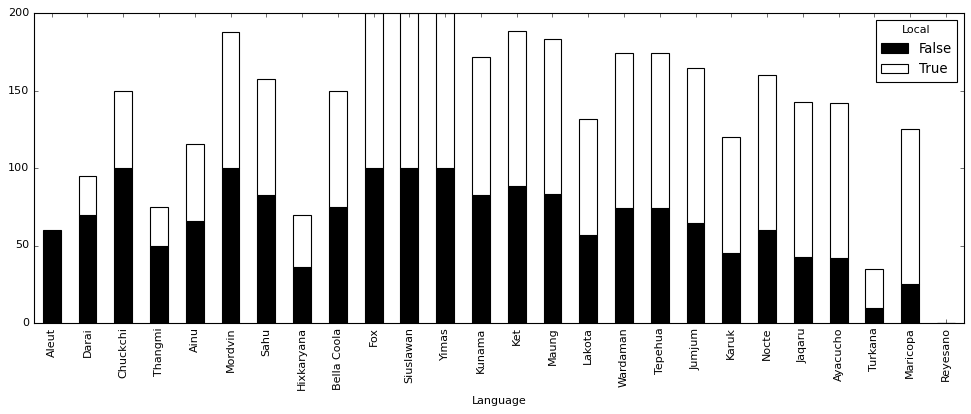

In [9]:
xf.sort_values(by=('Intrans (norm)', True), kind='mergesort')\
    ['Intrans'].plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

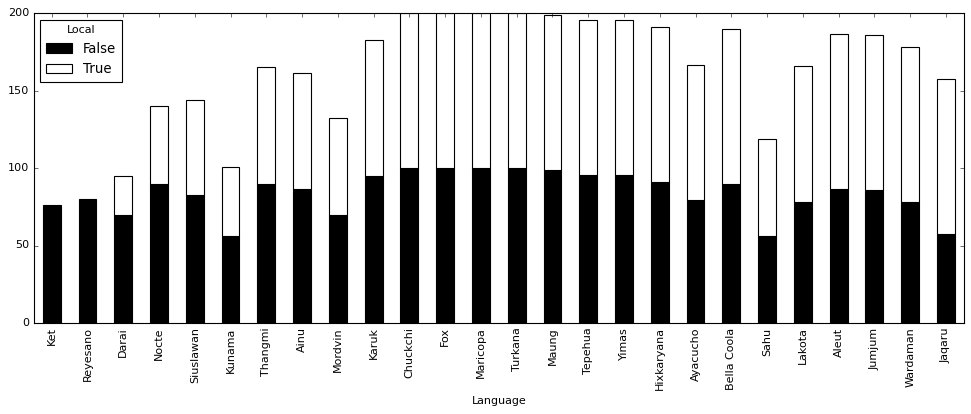

In [10]:
xf.sort_values(by=('AllPerfect (norm)', True), kind='mergesort')\
    ['AllPerfect'].plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

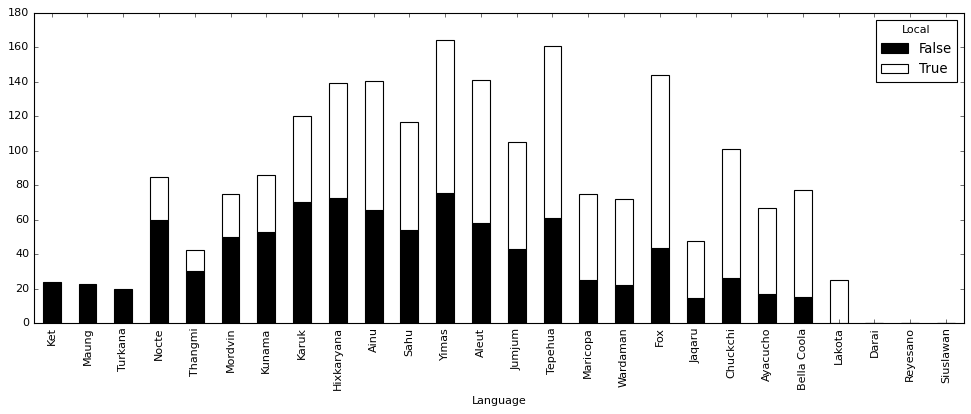

In [11]:
xf.sort_values(by=('All60/100 (norm)', True), kind='mergesort')\
    ['All60/100'].plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

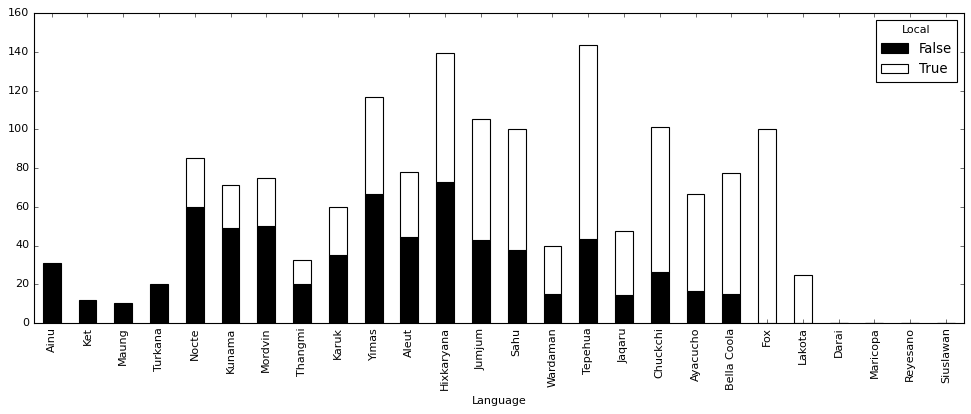

In [12]:
xf.sort_values(by=('All50/100 (norm)', True), kind='mergesort')\
    ['All50/100'].plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

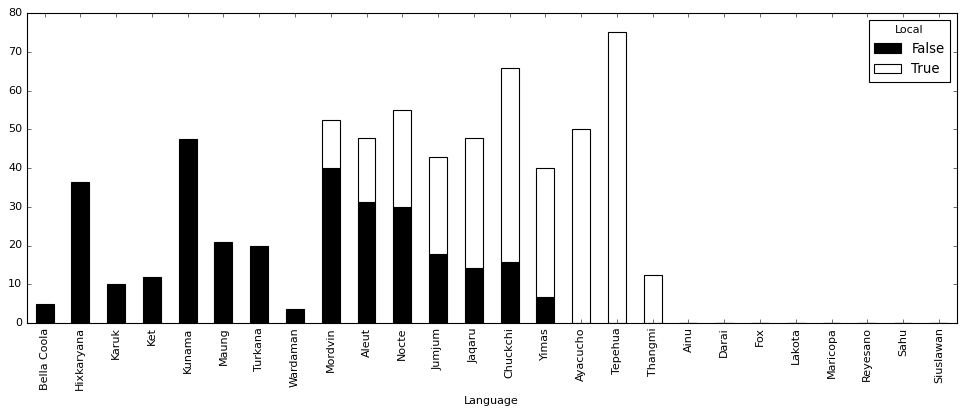

In [13]:
xf.sort_values(by=('All60 (norm)', True), kind='mergesort')\
    ['All60'].plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

In [14]:
df.stack('Local').corr().loc[disc[1:], disc[1:]]

Discharger,Intrans,FreePerfect,Free60/100,Free50/100,Free60,AllPerfect,AllIntransPerfect,All60/100,All50/100,All60
Discharger,,,,,,,,,,
Intrans,1.000000,0.385622,0.450496,0.422237,0.409808,0.100372,0.675281,0.181019,0.211517,0.172892
FreePerfect,0.385622,1.000000,0.535841,0.347679,0.350159,0.670971,0.412036,0.302966,0.256339,0.217824
Free60/100,0.450496,0.535841,1.000000,0.670234,0.624852,0.306996,0.348054,0.407894,0.326037,0.234178
Free50/100,0.422237,0.347679,0.670234,1.000000,0.840166,0.208151,0.242204,0.522919,0.638048,0.428336
Free60,0.409808,0.350159,0.624852,0.840166,1.000000,0.163024,0.251307,0.249879,0.320272,0.457837
AllPerfect,0.100372,0.670971,0.306996,0.208151,0.163024,1.000000,0.404220,0.446834,0.339513,0.183914
AllIntransPerfect,0.675281,0.412036,0.348054,0.242204,0.251307,0.404220,1.000000,0.195540,0.222130,0.119517
All60/100,0.181019,0.302966,0.407894,0.522919,0.249879,0.446834,0.195540,1.000000,0.820271,0.425964
All50/100,0.211517,0.256339,0.326037,0.638048,0.320272,0.339513,0.222130,0.820271,1.000000,0.573646


In [15]:
df.stack(['Local', 'Discharger']).to_frame('Ratio').reset_index('Local')\
    .groupby(level='Discharger').apply(lambda x: pearsonr(x, 'Local', 'Ratio')).loc[disc]

Local & Ratio,r,p
Discharger,,
None,NaN,NaN
Intrans,0.123610,0.382633
FreePerfect,-0.066892,0.637520
Free60/100,0.171901,0.223012
Free50/100,0.082854,0.559254
Free60,0.075947,0.592564
AllPerfect,-0.137421,0.331306
AllIntransPerfect,-0.006503,0.963507
All60/100,0.139123,0.325293


In [16]:
df.where(df.any(axis=1, level='Discharger'))\
    .stack(['Local', 'Discharger']).to_frame('Ratio').reset_index('Local')\
    .groupby(level='Discharger').apply(lambda x: pearsonr(x, 'Local', 'Ratio')).loc[disc]

Local & Ratio,r,p
Discharger,,
None,NaN,NaN
Intrans,0.140772,0.329511
FreePerfect,-0.066892,0.637520
Free60/100,0.193480,0.178217
Free50/100,0.095686,0.517669
Free60,0.094629,0.541198
AllPerfect,-0.137421,0.331306
AllIntransPerfect,-0.006927,0.961920
All60/100,0.170203,0.258107


In [17]:
with np.errstate(invalid='ignore'):
    _ = nf.round(2)[disc]
_

Discharger   None       Intrans       FreePerfect       Free60/100        \
Local       False True    False True        False True       False True    
Language                                                                   
Ainu          0.5   0.5    0.57  0.43        0.53  0.47       0.47  0.53   
Aleut         0.5   0.5    1.00  0.00        0.46  0.54       0.41  0.59   
Ayacucho      0.5   0.5    0.29  0.71        0.44  0.56       0.33  0.67   
Bella Coola   0.5   0.5    0.50  0.50        0.47  0.53       0.19  0.81   
Chuckchi      0.5   0.5    0.67  0.33        0.50  0.50       0.26  0.74   
Darai         0.5   0.5    0.74  0.26        0.76  0.24       0.76  0.24   
Fox           0.5   0.5    0.50  0.50        0.50  0.50       0.48  0.52   
Hixkaryana    0.5   0.5    0.52  0.48        0.48  0.52       0.52  0.48   
Jaqaru        0.5   0.5    0.30  0.70        0.46  0.54       0.36  0.64   
Jumjum        0.5   0.5    0.39  0.61        0.46  0.54       0.44  0.56   
Karuk         0.5   0.5    0.38  0.62        0.52  0.48       0.55  0.45   
Ket           0.5   0.5    0.47  0.53        0.48  0.52       0.38  0.62   
Kunama        0.5   0.5    0.48  0.52        0.48  0.52       0.52  0.48   
Lakota        0.5   0.5    0.43  0.57        0.47  0.53       0.00  1.00   
Maricopa      0.5   0.5    0.20  0.80        0.50  0.50       0.33  0.67   
Maung         0.5   0.5    0.45  0.55        0.50  0.50       0.52  0.48   
Mordvin       0.5   0.5    0.53  0.47        0.50  0.50       0.69  0.31   
Nocte         0.5   0.5    0.38  0.62        0.64  0.36       0.71  0.29   
Reyesano      0.5   0.5     NaN   NaN        1.00  0.00        NaN   NaN   
Sahu          0.5   0.5    0.52  0.48        0.47  0.53       0.46  0.54   
Siuslawan     0.5   0.5    0.50  0.50        0.48  0.52       0.48  0.52   
Tepehua       0.5   0.5    0.42  0.57        0.49  0.51       0.38  0.62   
Thangmi       0.5   0.5    0.67  0.33        0.55  0.45       0.71  0.29   
Turkana       0.5   0.5    0.29  0.71        0.50  0.50       0.41  0.59   
Wardaman      0.5   0.5    0.43  0.57        0.46  0.54       0.43  0.57   
Yimas         0.5   0.5    0.50  0.50        0.50  0.50       0.50  0.50   

Discharger  Free50/100        ... AllPerfect       AllIntransPerfect        \
Local            False True   ...      False True              False True    
Language                      ...                                            
Ainu              1.00  0.00  ...       0.53  0.47              1.00  0.00   
Aleut             0.57  0.43  ...       0.46  0.54              1.00  0.00   
Ayacucho          0.33  0.67  ...       0.48  0.52              0.18  0.82   
Bella Coola       0.19  0.81  ...       0.47  0.53              0.53  0.47   
Chuckchi          0.26  0.74  ...       0.50  0.50              0.67  0.33   
Darai             0.76  0.24  ...       0.74  0.26              0.74  0.26   
Fox               0.43  0.57  ...       0.50  0.50              0.50  0.50   
Hixkaryana        0.52  0.48  ...       0.48  0.52              0.52  0.48   
Jaqaru            0.36  0.64  ...       0.36  0.64              1.00  0.00   
Jumjum            0.44  0.56  ...       0.46  0.54              0.36  0.64   
Karuk             0.47  0.53  ...       0.52  0.48              0.39  0.61   
Ket               0.38  0.62  ...       1.00  0.00              1.00  0.00   
Kunama            0.69  0.31  ...       0.56  0.44              0.49  0.51   
Lakota            0.00  1.00  ...       0.47  0.53              0.26  0.74   
Maricopa           NaN   NaN  ...       0.50  0.50              0.20  0.80   
Maung             0.84  0.16  ...       0.50  0.50              0.45  0.55   
Mordvin           0.69  0.31  ...       0.53  0.47              0.51  0.49   
Nocte             0.71  0.29  ...       0.64  0.36              0.44  0.56   
Reyesano           NaN   NaN  ...       1.00  0.00               NaN   NaN   
Sahu              0.38  0.62  ...       0.47  0.53              1.00  0.00   
S

In [18]:
nf.stack(['Local', 'Discharger']).to_frame('Ratio').reset_index('Local')\
    .groupby(level='Discharger').apply(lambda x: pearsonr(x, 'Local', 'Ratio')).loc[disc]\
    .style.applymap(lambda x: x < .05 and 'background-color: lime' or '', subset=['p'])\
    .set_uuid('16')

Local & Ratio,r,p
Discharger,,
None,nan,nan
Intrans,0.094043,0.515945
FreePerfect,-0.201486,0.152042
Free60/100,0.281779,0.047429
Free50/100,0.009490,0.948958
Free60,0.122306,0.428998
AllPerfect,-0.302617,0.029216
AllIntransPerfect,-0.268690,0.059197
All60/100,0.028865,0.848976


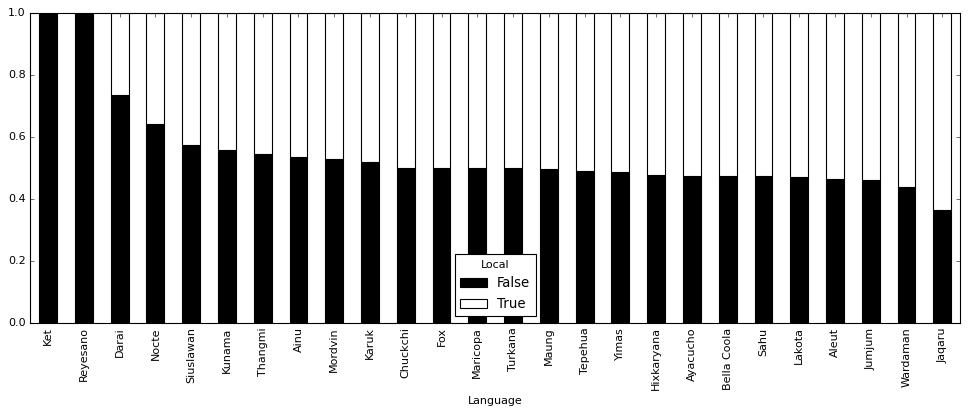

In [19]:
nf['AllPerfect'].sort_values(by=True, kind='mergesort')\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

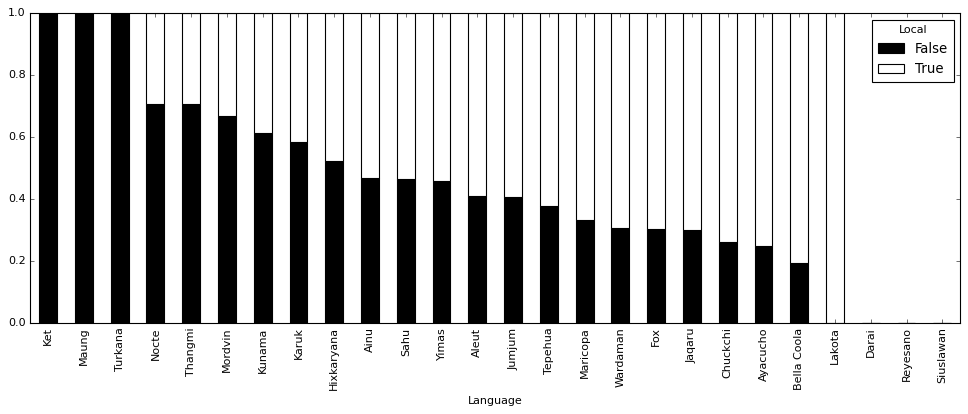

In [20]:
nf['All60/100'].sort_values(by=True, kind='mergesort')\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

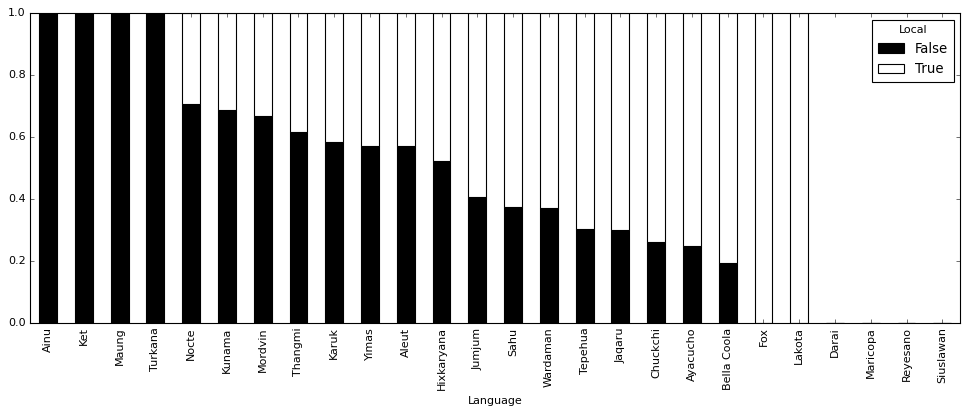

In [21]:
nf['All50/100'].sort_values(by=True, kind='mergesort')\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

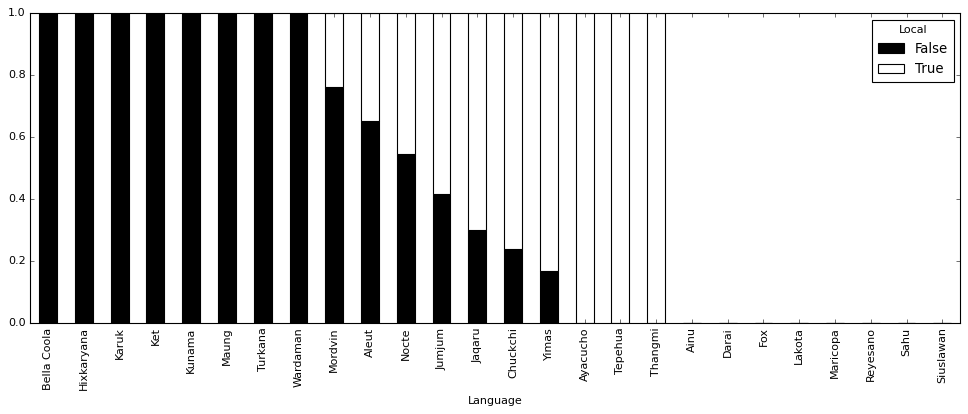

In [22]:
nf['All60'].sort_values(by=True, kind='mergesort')\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

## Direct

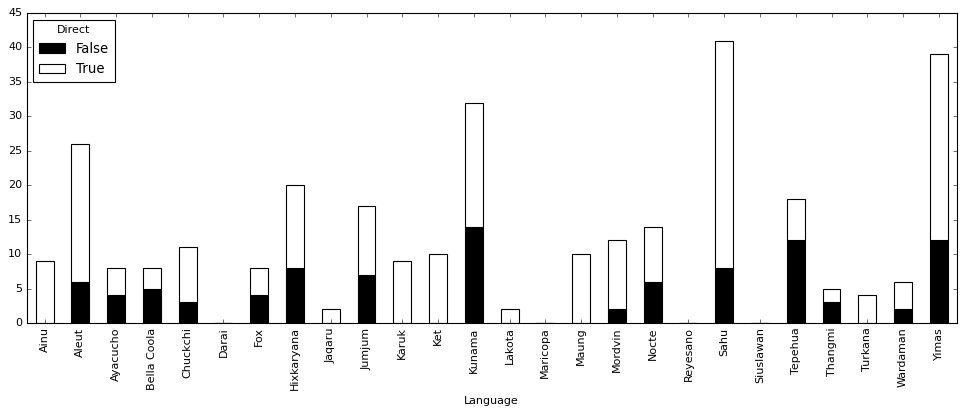

In [23]:
dff = tb[tb['Trans']]\
    .pivot_table('Form', 'Language', ['Discharger', 'Direct'], aggfunc='count', fill_value=0)

dff['All50/100'].plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

In [24]:
ddf = 100 * dff / dff['None']
dnf = ddf / ddf.sum(axis=1, level='Discharger')
with np.errstate(invalid='ignore'):
    _ = dnf.round(2)[disc]
_

Discharger   None       Intrans       FreePerfect       Free60/100        \
Direct      False True    False True        False True       False True    
Language                                                                   
Ainu          0.5   0.5    0.62  0.38        0.40  0.60       0.33  0.67   
Aleut         0.5   0.5    0.00  1.00        0.55  0.45       0.36  0.64   
Ayacucho      0.5   0.5    0.82  0.18        0.47  0.53       0.66  0.34   
Bella Coola   0.5   0.5    0.55  0.45        0.53  0.47       0.69  0.31   
Chuckchi      0.5   0.5    0.39  0.61        0.50  0.50       0.35  0.65   
Darai         0.5   0.5    0.31  0.69        0.40  0.60       0.40  0.60   
Fox           0.5   0.5    0.50  0.50        0.50  0.50       0.47  0.53   
Hixkaryana    0.5   0.5    0.73  0.27        0.53  0.47       0.55  0.45   
Jaqaru        0.5   0.5    0.83  0.17        0.56  0.44       0.71  0.29   
Jumjum        0.5   0.5    0.67  0.33        0.56  0.44       0.59  0.41   
Karuk         0.5   0.5    0.84  0.16        0.45  0.55       0.47  0.53   
Ket           0.5   0.5    0.54  0.46        0.53  0.47       0.45  0.55   
Kunama        0.5   0.5    0.58  0.42        0.52  0.48       0.65  0.35   
Lakota        0.5   0.5    0.47  0.53        0.53  0.47       0.00  1.00   
Maricopa      0.5   0.5    0.67  0.33        0.50  0.50       0.50  0.50   
Maung         0.5   0.5    0.56  0.44        0.50  0.50       0.48  0.52   
Mordvin       0.5   0.5    0.52  0.48        0.50  0.50       0.29  0.71   
Nocte         0.5   0.5    0.67  0.33        0.62  0.38       0.50  0.50   
Reyesano      0.5   0.5     NaN   NaN        0.57  0.43        NaN   NaN   
Sahu          0.5   0.5    0.50  0.50        0.24  0.76       0.25  0.75   
Siuslawan     0.5   0.5    0.50  0.50        0.47  0.53       0.47  0.53   
Tepehua       0.5   0.5    0.61  0.39        0.52  0.48       0.59  0.41   
Thangmi       0.5   0.5    0.00  1.00        0.57  0.43       0.50  0.50   
Turkana       0.5   0.5    0.57  0.43        0.50  0.50       0.62  0.38   
Wardaman      0.5   0.5    0.61  0.39        0.49  0.51       0.51  0.49   
Yimas         0.5   0.5    0.50  0.50        0.50  0.50       0.50  0.50   

Discharger  Free50/100        ... AllPerfect       AllIntransPerfect        \
Direct           False True   ...      False True              False True    
Language                      ...                                            
Ainu              0.00  1.00  ...       0.40  0.60              0.41  0.59   
Aleut             0.29  0.71  ...       0.55  0.45              0.00  1.00   
Ayacucho          0.66  0.34  ...       0.45  0.55              0.66  0.34   
Bella Coola       0.69  0.31  ...       0.53  0.47              0.55  0.45   
Chuckchi          0.35  0.65  ...       0.50  0.50              0.39  0.61   
Darai             0.40  0.60  ...       0.31  0.69              0.31  0.69   
Fox               0.49  0.51  ...       0.50  0.50              0.50  0.50   
Hixkaryana        0.55  0.45  ...       0.53  0.47              0.73  0.27   
Jaqaru            0.71  0.29  ...       0.43  0.57              1.00  0.00   
Jumjum            0.59  0.41  ...       0.56  0.44              0.64  0.36   
Karuk             0.44  0.56  ...       0.45  0.55              0.82  0.18   
Ket               0.45  0.55  ...       0.58  0.42              0.00  1.00   
Kunama            0.50  0.50  ...       0.41  0.59              0.90  0.10   
Lakota            0.00  1.00  ...       0.53  0.47              0.55  0.45   
Maricopa           NaN   NaN  ...       0.50  0.50              0.67  0.33   
Maung             0.39  0.61  ...       0.50  0.50              0.56  0.44   
Mordvin           0.29  0.71  ...       0.32  0.68              0.51  0.49   
Nocte             0.50  0.50  ...       0.62  0.38              1.00  0.00   
Reyesano           NaN   NaN  ...       0.57  0.43               NaN   NaN   
Sahu              0.33  0.67  ...       0.24  0.76              0.00  1.00   
S

In [25]:
dnf.stack(['Direct', 'Discharger']).to_frame('Ratio').reset_index('Direct')\
    .groupby(level='Discharger').apply(lambda x: pearsonr(x, 'Direct', 'Ratio')).loc[disc]\
    .style.applymap(lambda x: x < .05 and 'background-color: lime' or '', subset=['p'])\
    .set_uuid('21')

Direct & Ratio,r,p
Discharger,,
None,nan,nan
Intrans,-0.204242,0.154814
FreePerfect,-0.001038,0.994175
Free60/100,0.160060,0.266849
Free50/100,0.203384,0.165599
Free60,0.306644,0.042913
AllPerfect,0.228250,0.103633
AllIntransPerfect,-0.077528,0.592546
All60/100,0.531955,0.000142


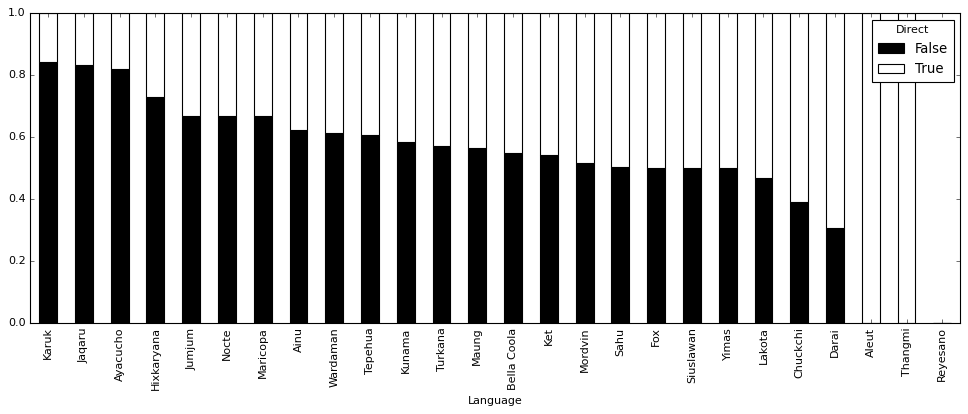

In [26]:
dnf['Intrans'].sort_values(by=True, kind='mergesort')\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

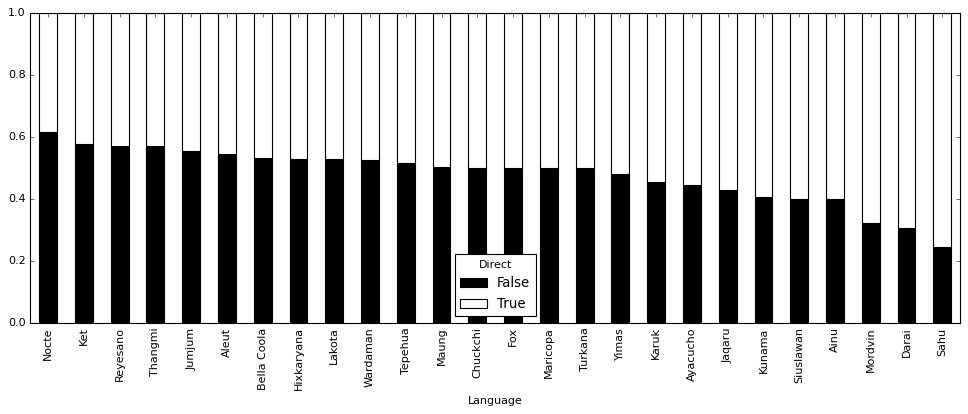

In [27]:
dnf['AllPerfect'].sort_values(by=True, kind='mergesort')\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

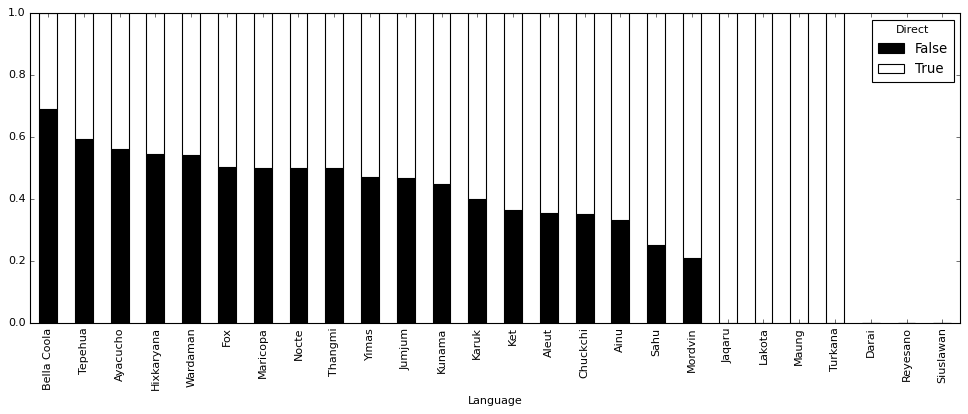

In [28]:
dnf['All60/100'].sort_values(by=True, kind='mergesort')\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

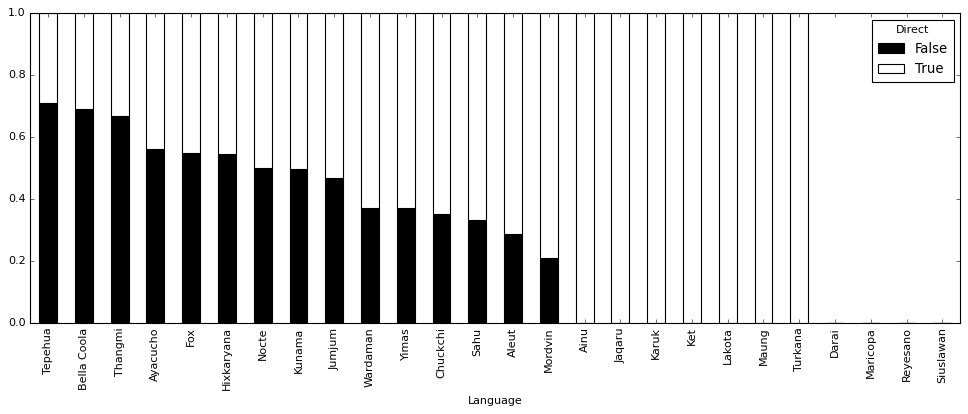

In [29]:
dnf['All50/100'].sort_values(by=True, kind='mergesort')\
    .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray);

## Local & form contingency

In [30]:
ctl = tb[tb['Trans']]\
    .set_index(['Language', 'Discharger', 'Cell', 'Local'])['Form'].notnull()\
    .unstack('Discharger')\
    .rename(columns={'None': 'Base'}).query('Base == 1').rename(columns={'Base': 'None'})\
    .stack('Discharger').to_frame('Form').reset_index()\
    .pivot_table('Cell', ['Language', 'Form'], ['Discharger', 'Local'], aggfunc=len, fill_value=0)

ctl[disc]

Discharger         None       Intrans       FreePerfect       Free60/100  \
Local             False True    False True        False True       False   
Language    Form                                                           
Ainu        False     0     0      10     4           4     2         10   
            True     29     8      19     4          25     6         19   
Aleut       False     0     0      18    18           6     0         19   
            True     45    18      27     0          39    18         26   
Ayacucho    False     0     0      14     0           5     0         15   
            True     24     8      10     8          19     8          9   
Bella Coola False     0     0       5     2           2     0         17   
            True     20     8      15     6          18     8          3   
Chuckchi    False     0     0       0     4           0     0         14   
            True     19     8      19     4          19     8          5   
Darai       False     0     0       6     6           4     6          4   
            True     20     8      14     2          16     2         16   
Fox         False     0     0       0     0           0     0          2   
            True     32     8      32     8          32     8         30   
Hixkaryana  False     0     0      14     4           2     0          6   
            True     22     6       8     2          20     6         16   
Jaqaru      False     0     0       4     0           1     0          3   
            True      7     3       3     3           6     3          4   
Jumjum      False     0     0      10     0           4     0          6   
            True     28     8      18     8          24     8         22   
Karuk       False     0     0      11     2           1     1          5   
            True     20     8       9     6          19     7         15   
Ket         False     0     0      10     0           8     0         32   
            True     84     8      74     8          76     8         52   
Kunama      False     0     0      10     2           5     0         15   
            True     57    18      47    16          52    18         42   
Lakota      False     0     0      10     2           5     1         23   
            True     23     8      13     6          18     7          0   
Maricopa    False     0     0      12     0           0     0         12   
            True     16     8       4     8          16     8          4   
Maung       False     0     0      16     0           0     0          5   
            True     96     8      80     8          96     8         91   
Mordvin     False     0     0       0     1           0     0          9   
            True     20     8      20     7          20     8         11   
Nocte       False     0     0       8     0           2     4          8   
            True     20     8      12     8          18     4         12   
Reyesano    False     0     0      20     8           4     8         20   
            True     20     8       0     0          16     0          0   
Sahu        False     0     0      17     2          42     3         44   
            True     96     8      79     6          54     5         52   
Siuslawan   False     0     0       0     0           4     0          4   
            True     57    18      57    18          53    18         53   
Tepehua     False     0     0       6     0           1     0          9   
            True     23     8      17     8          22     8         14   
Thangmi     False     0     0      10     6           2     2         14   
            True     20     8      10     2          18     6          6   
Turkana     False     0     0      18     6           0     0          6   
            True     20     8       2     2          20     8         14   
Wardaman    False     0     0       7     0           4     0          7   
            True     27     8      20     8     

In [31]:
ctl.stack('Discharger')\
    .groupby(level=['Discharger', 'Language']).apply(fisher_exact).query('p <= .05')\
    .assign(i=lambda x: list(map(disc.tolist().index, x.index.get_level_values('Discharger'))))\
    .reset_index().set_index(['i', 'Discharger', 'Language']).sort_index()

odds             p
i  Discharger        Language                            
1  Intrans           Aleut         0.000000  6.797740e-06
                     Ayacucho           inf  4.445680e-03
                     Chuckchi      0.000000  3.988604e-03
                     Darai         0.142857  4.405160e-02
                     Maricopa           inf  1.346076e-03
2  FreePerfect       Darai         0.083333  1.104692e-02
                     Nocte         0.111111  3.835006e-02
                     Reyesano      0.000000  1.592610e-04
3  Free60/100        Bella Coola   9.444444  2.230330e-02
                     Chuckchi      8.400000  3.322185e-02
                     Darai         0.083333  1.104692e-02
                     Ket                inf  4.700267e-02
4  Free50/100        Bella Coola   9.444444  2.230330e-02
                     Chuckchi      8.400000  3.322185e-02
                     Darai         0.083333  1.104692e-02
                     Ket                inf  4.700267e-02
                     Maung         0.074830  4.930952e-03
                     Tepehua            inf  9.625510e-03
5  Free60            Ayacucho     11.400000  9.898463e-03
                     Bella Coola   9.444444  2.230330e-02
                     Darai         0.083333  1.104692e-02
                     Ket                inf  1.902499e-02
                     Kunama        0.000000  1.205725e-04
                     Maung         0.093333  3.636695e-03
                     Siuslawan          inf  1.208441e-02
                     Tepehua            inf  3.802896e-05
6  AllPerfect        Darai         0.142857  4.405160e-02
                     Ket           0.000000  3.339144e-05
                     Nocte         0.111111  3.835006e-02
                     Reyesano      0.000000  1.592610e-04
7  AllIntransPerfect Ainu          0.000000  1.211601e-02
                     Aleut         0.000000  6.797740e-06
                     Ayacucho     15.000000  4.867231e-03
                     Chuckchi      0.000000  3.988604e-03
                     Darai         0.142857  4.405160e-02
                     Jumjum             inf  3.337695e-02
                     Maricopa           inf  1.346076e-03
                     Wardaman           inf  1.524523e-02
                     Yimas         0.241758  3.759624e-02
8  All60/100         Bella Coola   9.444444  2.230330e-02
                     Chuckchi      8.400000  3.322185e-02
                     Fox                inf  4.726994e-03
9  All50/100         Bella Coola   9.444444  2.230330e-02
                     Chuckchi      8.400000  3.322185e-02
                     Fox                inf  1.300311e-08
                     Tepehua            inf  9.625510e-03
10 All60             Ayacucho           inf  1.946607e-03
                     Kunama        0.000000  1.205725e-04
                     Tepehua            inf  3.802896e-05
                     Yimas         7.000000  1.254650e-02